EDA


Train dataset shape: (1460, 81)
Test dataset shape: (1459, 80)
Submission dataset shape: (1459, 2)

Train data preview:
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...  

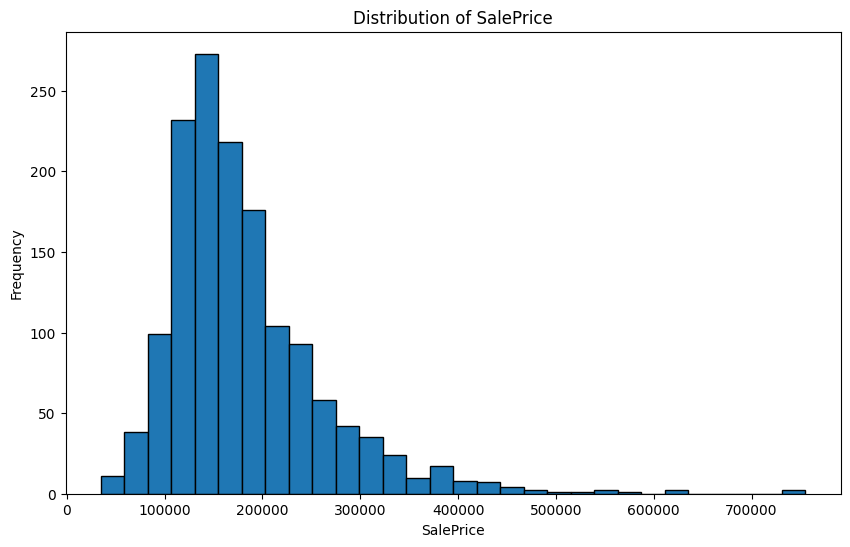

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the datasets
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')
submission_df = pd.read_csv('/content/sample_submission.csv')

# Display basic information about the datasets
print("Train dataset shape:", train_df.shape)
print("Test dataset shape:", test_df.shape)
print("Submission dataset shape:", submission_df.shape)
print("\nTrain data preview:")
print(train_df.head())

# Check missing values in the training data
missing_train = train_df.isnull().sum().sort_values(ascending=False)
print("\nMissing values in training data:")
print(missing_train[missing_train > 0])

# Visualize the distribution of the target variable 'SalePrice'
plt.figure(figsize=(10,6))
plt.hist(train_df['SalePrice'], bins=30, edgecolor='k')
plt.title('Distribution of SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.show()


Correlation Matrix


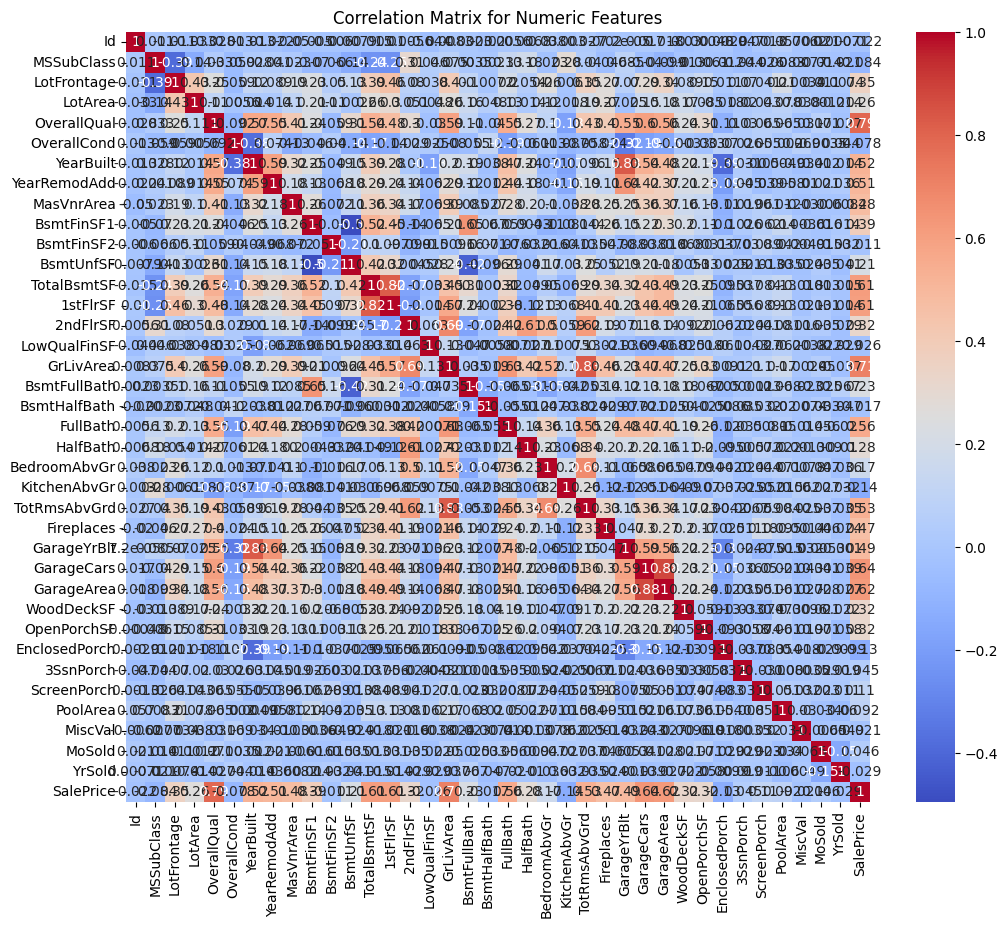

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select only numeric columns for correlation
numeric_df = train_df.select_dtypes(include=['int64', 'float64'])
corr = numeric_df.corr()

# Plot the correlation matrix using seaborn
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix for Numeric Features")
plt.show()



Handling Missing Values

In [4]:
# For numerical features: impute with median
num_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
train_df[num_cols] = train_df[num_cols].fillna(train_df[num_cols].median())

# For categorical features: impute with mode
cat_cols = train_df.select_dtypes(include=['object']).columns
for col in cat_cols:
    train_df[col] = train_df[col].fillna(train_df[col].mode()[0])

# One-hot encoding categorical variables
train_df_encoded = pd.get_dummies(train_df, drop_first=True)
print("Shape after encoding:", train_df_encoded.shape)


Shape after encoding: (1460, 246)


Feature Engineering


In [12]:
#House Age calculation
# Calculate HouseAge and add it as a new column
train_df['HouseAge'] = train_df['YrSold'] - train_df['YearBuilt']

# Print the first few rows to verify
print(train_df[['YearBuilt', 'YrSold', 'HouseAge']].head())



   YearBuilt  YrSold  HouseAge
0       2003    2008         5
1       1976    2007        31
2       2001    2008         7
3       1915    2006        91
4       2000    2008         8


In [9]:
import numpy as np
train_df_encoded['SalePrice'] = np.log(train_df_encoded['SalePrice'])


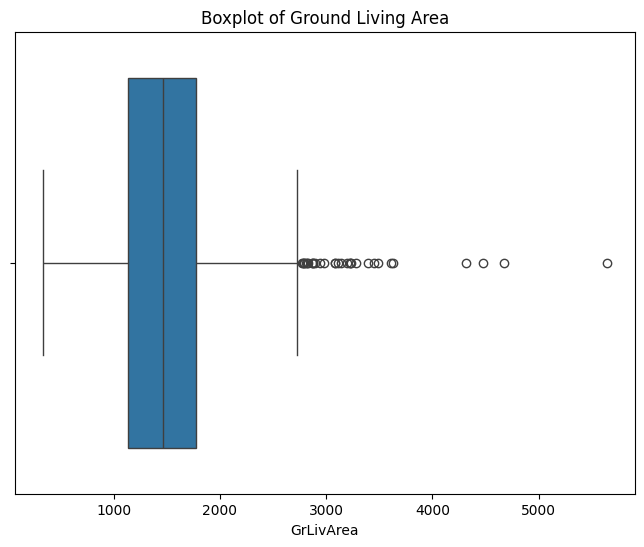

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.boxplot(x=train_df['GrLivArea'])
plt.title("Boxplot of Ground Living Area")
plt.show()


Model Building

Baseline Linear Regression RMSE: 51405.094253333926


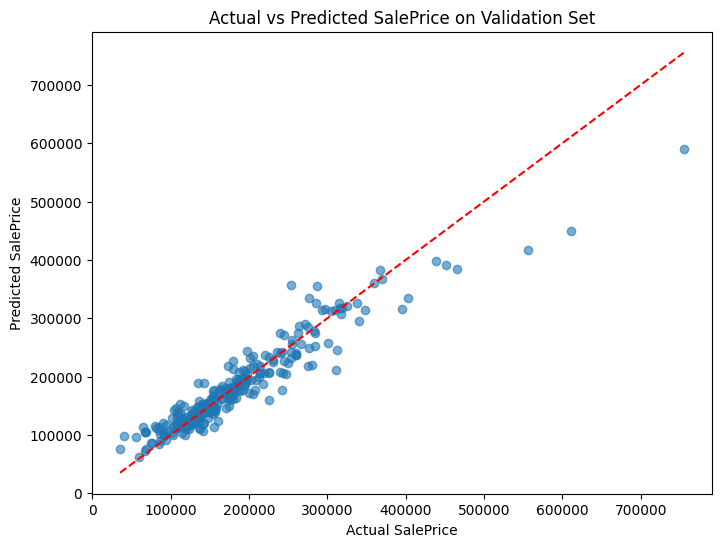

Submission file saved as submission.csv


In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Separate target variable from training set
y = train_df['SalePrice']
X_train = train_df.drop('SalePrice', axis=1)
X_test = test_df

# Combine training and test data for consistent processing
combined = pd.concat([X_train, X_test], keys=['train', 'test'])

# Identify numeric and categorical columns
numeric_cols = combined.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = combined.select_dtypes(include=['object']).columns

# Impute missing values
combined[numeric_cols] = combined[numeric_cols].fillna(combined[numeric_cols].median())
for col in categorical_cols:
    combined[col] = combined[col].fillna(combined[col].mode()[0])

# One-hot encode categorical features
combined_encoded = pd.get_dummies(combined, drop_first=True)

# Split the combined dataset back into training and test sets
X_train_encoded = combined_encoded.xs('train')
X_test_encoded = combined_encoded.xs('test')

# Split the training set into training and validation sets for model evaluation
X_tr, X_val, y_tr, y_val = train_test_split(X_train_encoded, y, test_size=0.2, random_state=42)

# Train a Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_tr, y_tr)

# Evaluate the model using RMSE
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
print("Baseline Linear Regression RMSE:", rmse)

# Plot actual vs predicted values for the validation set
plt.figure(figsize=(8,6))
plt.scatter(y_val, y_pred_val, alpha=0.6)
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Actual vs Predicted SalePrice on Validation Set")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='red', linestyle='--')
plt.show()

# Generate predictions for the test set
test_preds = model.predict(X_test_encoded)

# Prepare the submission DataFrame using the 'Id' column from test data
submission = pd.DataFrame({
    'Id': X_test_encoded.index,
    'SalePrice': test_preds
})
submission.to_csv('submission.csv', index=False)
print("Submission file saved as submission.csv")